Author: Doug Branton, Neven Caplar and the LINCC Frameworks team

Last updated: November 13, 2025

## Problem 3

## Use quality flags to clean photometry

In the previous notebook above, we've forgotten an important pre-processing step, filtering our photometry based on quality flags. For this exercise, compute periodograms for the ZTF DR22 lightcurves again, but this time only using photometry with no quality flags set in `catflags`. Optionally, look at the same object in this notebook at the end to see how the lightcurve has changed by including a quality flag cut. Feel free to re-use any and all code shown in the previous notebook in the result.

# Solution 3

In [1]:
import lsdb
from nested_pandas.utils import count_nested
from lsdb import ConeSearch
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Configuration settings
rcParams["savefig.dpi"] = 550
rcParams["font.size"] = 20
plt.rc("font", family="serif")
mpl.rcParams["axes.linewidth"] = 2

# Define the six fields from Data Preview 1 with RA and Dec coordinates
fields = {
    "ECDFS": (53.13, -28.10),  # Extended Chandra Deep Field South
    "EDFS": (59.10, -48.73),  # Euclid Deep Field South
    "Rubin_SV_38_7": (37.86, 6.98),  # Low Ecliptic Latitude Field
    "Rubin_SV_95_-25": (95.00, -25.00),  # Low Galactic Latitude Field
    "47_Tuc": (6.02, -72.08),  # 47 Tuc Globular Cluster
    "Fornax_dSph": (40.00, -34.45)  # Fornax Dwarf Spheroidal Galaxy
}

# Define a 0.2-degree (0.2*3600 arcseconds) search radius
radius_arcsec = 0.2 * 3600  # Convert 0.2 degree to arcseconds
# Create six cone searches
cones = {name: ConeSearch(ra=ra, dec=dec, radius_arcsec=radius_arcsec) for name, (ra, dec) in fields.items()}

In [2]:
# Load ZTF DR22
ztf_ndf = lsdb.open_catalog('https://data.lsdb.io/hats/ztf_dr22/ztf_lc',
                            margin_cache='https://data.lsdb.io/hats/ztf_dr22/ztf_lc_10arcs',
                            search_filter=cones["Rubin_SV_95_-25"]).compute()

# The timeseries data in this dataset is stored as lists, we can convert these into a nested column
ztf_ndf = ztf_ndf.nest_lists(columns=["hmjd","mag","magerr","clrcoeff","catflags"], name="timeseries")
ztf_ndf

objectid  filterid      objra     objdec  nepochs  \
_healpix_29                                                                     
1450136709898271135  258108400000047         1  95.040352  -25.19565      157   
1450136709898294367  258208400000023         2  95.040352 -25.195646      457   
...                              ...       ...        ...        ...      ...   
1456155336767175581  258108100004227         1   94.99221 -24.804495       29   
1456155336769478700  258208100007410         2  94.992165 -24.804405      354   

                                                            timeseries  
_healpix_29                                                             
1450136709898271135  [{hmjd: 58205.13356, mag: 16.904661, magerr: 0...  
1450136709898294367  [{hmjd: 58397.52197, mag: 16.151007, magerr: 0...  
...                                                                ...  
1456155336767175581  [{hmjd: 58423.449, mag: 19.983234, magerr: 0.1...  
1456155336769478700  [{hmjd: 58397.52198, mag: 19.669369, magerr: 0...  

[6924 rows x 6 columns]

In [3]:
# Filter on catflags
ztf_ndf_good_phot = ztf_ndf.query("timeseries.catflags == 0")
ztf_ndf_good_phot

# Count new lengths and filter
ztf_ndf_good_phot = count_nested(ztf_ndf_good_phot, "timeseries", join=True)
ztf_ndf_good_phot = ztf_ndf_good_phot.query("n_timeseries > 100")
ztf_ndf_good_phot

objectid  filterid      objra     objdec  nepochs  \
_healpix_29                                                                     
1450136709898271135  258108400000047         1  95.040352  -25.19565      157   
1450136709898294367  258208400000023         2  95.040352 -25.195646      457   
...                              ...       ...        ...        ...      ...   
1456155315393785536  258208100007398         2  94.959763 -24.803455      364   
1456155336769478700  258208100007410         2  94.992165 -24.804405      354   

                                                            timeseries  \
_healpix_29                                                              
1450136709898271135  [{hmjd: 58423.44054, mag: 16.812403, magerr: 0...   
1450136709898294367  [{hmjd: 58397.52197, mag: 16.151007, magerr: 0...   
...                                                                ...   
1456155315393785536  [{hmjd: 58397.52198, mag: 19.500437, magerr: 0...   
1456155336769478700  [{hmjd: 58397.52198, mag: 19.669369, magerr: 0...   

                     n_timeseries  
_healpix_29                        
1450136709898271135           126  
1450136709898294367           292  
...                           ...  
1456155315393785536           293  
1456155336769478700           288  

[2708 rows x 7 columns]

In [4]:
# Calculate Periods
from astropy.timeseries import LombScargle

# Define a periodogram calculator function, using astropy's LombScargle
def extract_period(time, mag, error):
    ls = LombScargle(time, mag, error)
    freq, power = ls.autopower()
    argmax = np.argmax(power)
    period = 1.0 / freq[argmax]
    false_alarm_prob = ls.false_alarm_probability(power[argmax])
    return {"period": period, "false_alarm_prob": false_alarm_prob}

# Apply our function to each timeseries via reduce
periods_ndf = ztf_ndf_good_phot.reduce(
    extract_period,
    # Column names specifying function arguments
    "timeseries.hmjd",
    "timeseries.mag",
    "timeseries.magerr",
)
periods_ndf

ztf_w_periods = ztf_ndf_good_phot.join(periods_ndf)

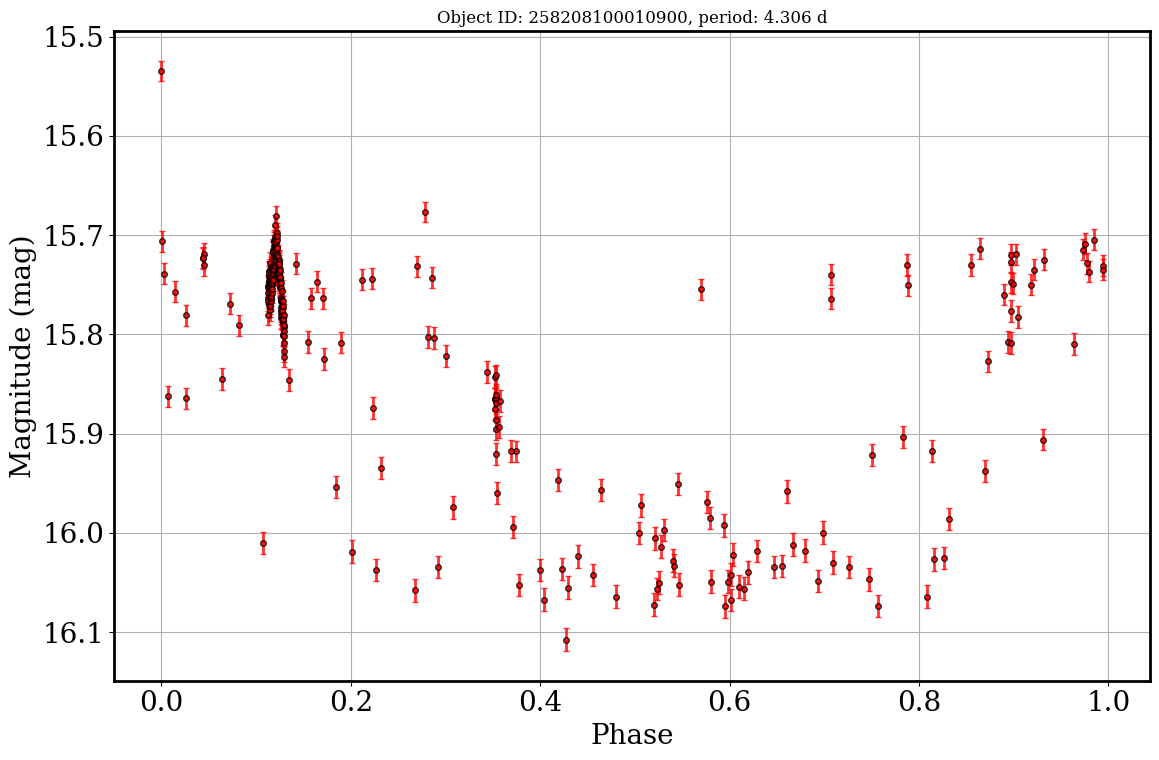

In [5]:
# Pick an interesting result by eye
interesting_idx = 1456145241786570789

import matplotlib.pyplot as plt

row = ztf_w_periods.loc[interesting_idx]
lc = row.timeseries

peak_mjd = lc["hmjd"][lc["mag"].idxmin()]
lc["phase"] = (lc["hmjd"] - peak_mjd) % row.period / row.period

# Create figure with nice styling
fig, ax = plt.subplots(figsize=(12, 8))

ax.errorbar(
    lc["phase"],
    lc["mag"],
    yerr=lc["magerr"],
    fmt="o",
    color="red",
    ecolor="red",
    elinewidth=2,
    capsize=2,
    alpha=0.8,
    markeredgecolor="k",
    markersize=4,
)

ax.invert_yaxis()
ax.set_xlabel("Phase")
ax.set_ylabel("Magnitude (mag)")
ax.set_title(f"Object ID: {row.objectid}, period: {row.period:.3f} d", fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()